# Homework 1: Using Least Squares for Modeling Bitcoin Prices, and Solving the Point Set Registration Problem.


**1.**
Related with the nature of the data, which conditions should meet matrices $A$ and $b$ to be solvable from the least squares perspective.

Let $n\times m$ be the size of $A$. As we've seen, this means that the set of our training examples is of size $n$, and that we are considering a model with $m$ parameters, each of them being the coefficient of some function defined on a set $C\subseteq\mathbb{R}$. Considering the previous observation, we notice that it would only make sense to construct such model which fits best the dataset using this method whenever **$n\geq m$**, since otherwise, if $n<m$, were we able to solve the problem with least queares we would most likely come up with an infinite amount of possible models that fit the training set perfectly, are more complex than the dataset itself and easily overfit hugely, which is not really useful at all.

In the second place, given the previous condition, we know that a vector $x$ is a minimizer of the function $\| Ax - b \|_2^2$ if and only if the vector $x$ satisfies the normal ecuations $A^T A x = A^T b$. Thus, in order for our problem to be solvable from the least squares perspective, **we need $A^Tb$ to be in the column space of matrix $A^TA$**. 
The most convenient way under which this condition can be met, is whenever $A^TA$ is invertible, since in this case we would be able to solve the problem for any given vector $b$ and would obtain only one minimizer. 

Now, using linear algebra it can be shown that this convenient condition consisting in $A^TA$ being invertible is actually equivalent to $A$ having full rank, i.e., **the columns of matrix $A$ being linearly independent (dim A=m)**. So the lather is our final condition.

**2.** Use a least squares for non-linear models to adjust the bitcoin price and perform a prediction using the model to determine the future daily price a week ahead, compare with the actual values.

In order to choose our non-linear model, let's first see how the data behaves around the linear adjustment. 

First we read bitcoin data, and get the optimal linear model using least squares.

In [1]:
#=import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("PlotlyJS")
Pkg.add("Convex")
Pkg.add("SCS")
=#

In [2]:
using CSV
using DataFrames

dataBitcoin = CSV.read("C:\\Users\\Ramos\\Documents\\Life\\University\\2022-1S\\Courses\\Aprendizaje de Máquina\\Tarea1\\bitco1.csv",DataFrame);
sort!(dataBitcoin);
dataBitcoin.Price .= replace.(dataBitcoin.Price, "," => "");
dataBitcoin.PriceFloat = parse.(Float64, dataBitcoin.Price)
println(dataBitcoin)

29×8 DataFrame
 Row │ Date          Price     Open      High      Low       Vol.     Change %  PriceFloat 
     │ String15      String15  String15  String15  String15  String7  String7   Float64    
─────┼─────────────────────────────────────────────────────────────────────────────────────
   1 │ Feb 07, 2022  43833.9   42,385.2  44,468.3  41,695.4  76.60K   3.40%        43833.9
   2 │ Feb 08, 2022  44038.2   43,833.9  45,399.8  42,705.0  92.88K   0.47%        44038.2
   3 │ Feb 09, 2022  44388.9   44,038.2  44,800.4  43,163.0  50.92K   0.80%        44388.9
   4 │ Feb 10, 2022  43521.0   44,388.9  45,755.2  43,242.5  89.69K   -1.96%       43521.0
   5 │ Feb 11, 2022  42388.4   43,519.3  43,915.1  42,023.4  69.95K   -2.60%       42388.4
   6 │ Feb 12, 2022  42205.2   42,388.4  43,006.4  41,776.8  37.88K   -0.43%       42205.2
   7 │ Feb 13, 2022  42061.1   42,205.5  42,725.1  41,880.1  25.88K   -0.34%       42061.1
   8 │ Feb 14, 2022  42550.3   42,061.1  42,799.7  41,591.3  53.60K   1.

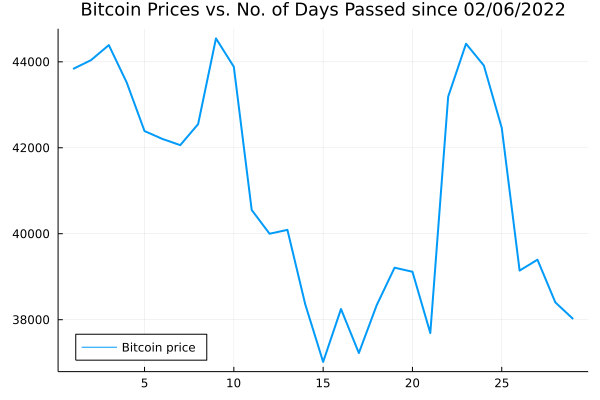

In [5]:
using Plots

plot(dataBitcoin.PriceFloat, label= "Bitcoin price", title= "Bitcoin Prices vs. No. of Days Passed since 02/06/2022", lw=2, titlefontsize=12,legend= :bottomleft)

In [6]:
#Construction of matrix A (named Alin), and vector b

N = size(dataBitcoin.PriceFloat,1);
Alin = Array((1:N));
b = Array(dataBitcoin.PriceFloat);
Alin = [ones(N,1) Alin];

In [7]:
using LinearAlgebra


#least squares solver function

function leastsq(A,b)

#=takes A a mxn matrix, b an n-dimensional vector
Returns [x,y] where x=(A^TA)\(A^Tb) and y=Ax 
=#  
x=transpose(A)*A \ (transpose(A)*b);
y= A*x;
return [x,y];  
    
end;

Now we display a graph of our data along with the linear model obtained previously, and calculate the mean squared error of the adjustment.

Mean squared error of linear adjustment: 4.740835e6



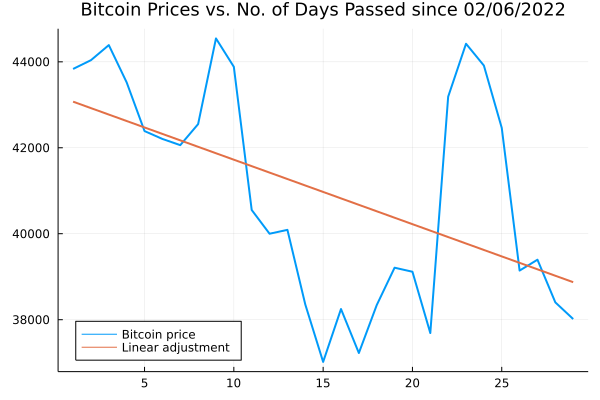

In [8]:
#using leastsq solver function for linear adjustment of bitcoin prices

lin = leastsq(Alin, b)[2]

#calculating mean squared error

elin=1/N*norm(lin-b)^2

println("Mean squared error of linear adjustment: ", round(elin), "\n")

plot(Alin[:,2],b, label= "Bitcoin price", title= "Bitcoin Prices vs. No. of Days Passed since 02/06/2022", titlefontsize=12, lw=2, legend= :bottomleft)
plot!(Alin[:,2],lin, label="Linear adjustment", lw=2)


With the purpose of choosing our non-linear model, we plot the difference between the data points and the previous linear adjustment, to see the data's behaviour around it.

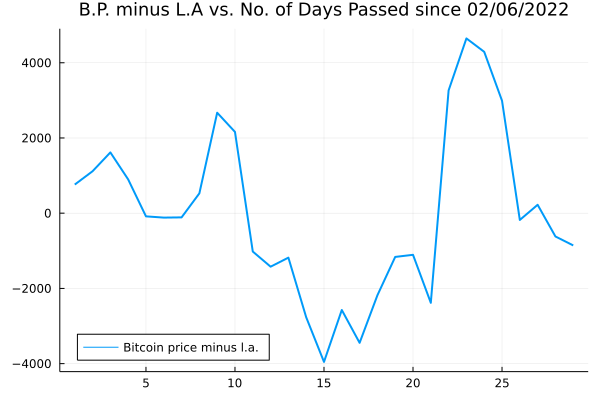

In [9]:
diff=b-lin;

#in this particular case we abbreviate bitcoin price and Linear adjustment with B.P and L.A for size reasons

plot(Alin[:,2],diff, label= "Bitcoin price minus l.a.",  title= "B.P. minus L.A vs. No. of Days Passed since 02/06/2022", titlefontsize=12, lw=2, legend= :bottomleft)

Here the data seems to have a similar behaviour as a pereiodic function such as cosine and sine, so we'll construct a model for this new dataset given by the function $f(\alpha_1,\alpha_2,\alpha_3,x)= \alpha_1+\alpha_2 \cos(x)+\alpha_3\sin(x)$, with parameters $\alpha_1,\alpha_2,\alpha_3\in\mathbb{R}$, and then add it to the linear adjustment to obtain a model for the original data.

In order to achieve this we first create our $29\times3$-sized matrix, which we'll call $Atrigd$.

In [10]:
Atrigd= [ones(N,1) cos.(Array((1:N))) sin.(Array((1:N)))];

Solving the normal equations we get our minimum argument vector $xtrigd$, and calculate the mean squared error of our optimal solution. 

In [11]:
xtrigd = leastsq(Atrigd,diff)[1];
ytrigd= leastsq(Atrigd,diff)[2];
println("Least squares solution for Atrigd*x=diff : ", round.(xtrigd, digits=3))

Least squares solution for Atrigd*x=diff : [6.687, -308.392, -513.2]


Set $$\begin{equation} \label{eq1}
\begin{split}
f(x) & =f(\text{xtrigd}^1,\text{xtrigd}^2,\text{xtrigd}^3,x) \\
 & = 6.687 -308.392\text{cos(x)} -513.2\text{sen(x)},
\end{split}
\end{equation}$$

the obtained model through least squares. We now can now plot this model along with our dataset.

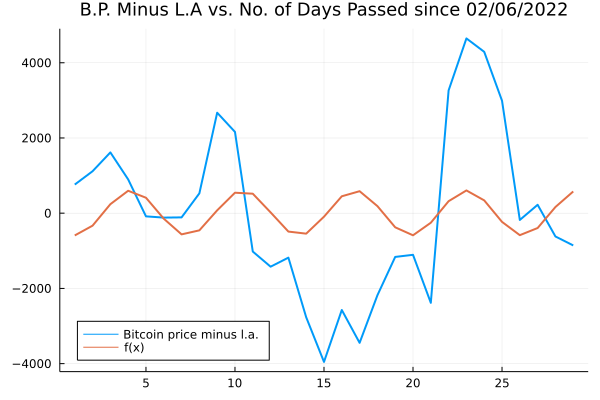

In [12]:
plot(Alin[:,2], diff, title= "B.P. Minus L.A vs. No. of Days Passed since 02/06/2022", titlefontsize=12, label="Bitcoin price minus l.a." ,lw=2, legend= :bottomleft)
plot!(Alin[:,2],ytrigd, label= "f(x)", lw=2)

And finally we plot our original data with the chosen model, which will be the sum of the previous model and the linear adjustment we had substracted in the firs place, and calculate the mean squared error of this second bitcoin price model:

Mean squared error of second model: 4.557034e6


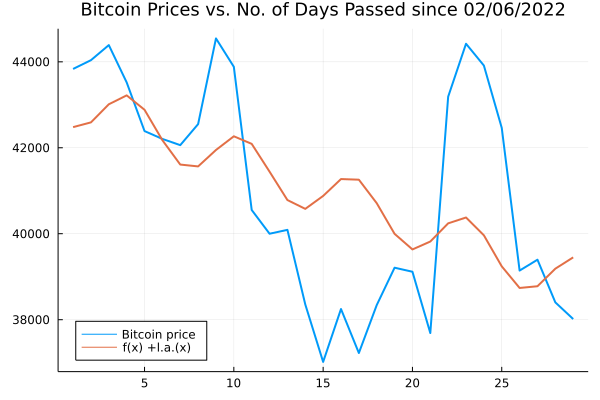

In [13]:
e2=1/N*norm(ytrigd-diff)^2

println("Mean squared error of second model: ", round(e2))
plot(Alin[:,2], b, title= "Bitcoin Prices vs. No. of Days Passed since 02/06/2022", titlefontsize=12, lw=2, legend= :bottomleft, label="Bitcoin price")
plot!(Alin[:,2],ytrigd+lin, lw=2, label="f(x) +l.a.(x)")

We notice, however, that we could have a more precise model adding the linear parameter to our previous model directly, and not by setting the linear parameters as the obtained with the linear adjustment.

So let's do this new parameterized model given by $g(\beta_1,\beta_2,\beta_3,\beta_4,x)=\beta_1+\beta_2x+\beta_3\sin(x)+\beta_4\cos(x)$, which again takes as input the number of days and has $\beta_1,\beta_2,\beta_3,\beta_4$ as parameters.

In [14]:
ATrig= [ones(N,1) Array((1:N)) cos.(Array((1:N))) sin.(Array((1:N)))];

Solving the normal equations we get our minimum vector $xtrig$, and calculate the mean squared error of this optimal solution.

In [17]:
strig = leastsq(ATrig,b);
xtrig=strig[1];
ytrig=strig[2];

xtrig
eg=1/N*norm(ytrig-b)^2 #error calculation
println("Least squares solution for Atrig*x=b : ", round.(xtrig, digits=3),"\n")
println("Mean squared error of third model: ", round(eg))

Least squares solution for Atrig*x=b : [43284.037, -153.667, -310.392, -515.537]

Mean squared error of third model: 4.556101e6


Set $$\begin{equation} \label{eq1}
\begin{split}
g(x) & =g(\text{xtrig}^1,\text{xtrig}^2,\text{xtrig}^3,\text{xtrig}^4,x) \\
 & = 43284.037 -153.667x -310.392\text{cos(x)} -515.537\text{sen(x)},
\end{split}
\end{equation}$$

the obtained model through least squares. Now we compare this mean squared error with the obtained with the previous model.

In [18]:
abserrorTM= eg-e2
relerrorTM=abserrorTM/e2
println("Relative error between g(x) and f(x)+l.a.(x) mean squared errors: ", round(relerrorTM,digits=4))

Relative error between g(x) and f(x)+l.a.(x) mean squared errors: -0.0002


We can conclude that the model didn't get significantly better. However we'll keep working with this model since it's already stored and not a lot more difficult to implement.

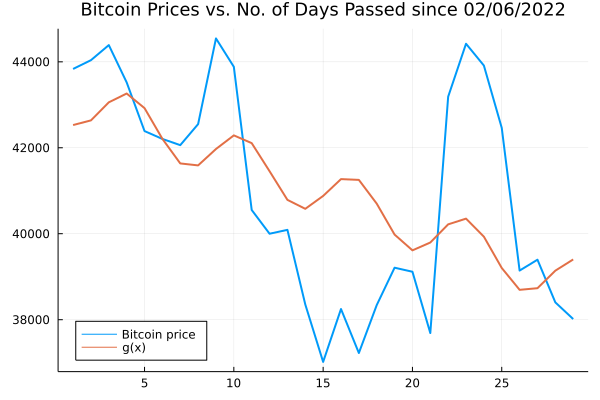

In [19]:
plot(Alin[:,2], b, title= "Bitcoin Prices vs. No. of Days Passed since 02/06/2022", titlefontsize=12, lw=2, legend= :bottomleft, label="Bitcoin price")
plot!(Alin[:,2],ytrig, label="g(x)", lw=2)

Now lets see it's precision in predicting the following next day's bitcoin prices.

First we store this data on the dataframe dataBitcoin2.

In [20]:
using CSV
using DataFrames

dataBitcoin2 = CSV.read("C:\\Users\\Ramos\\Documents\\Life\\University\\2022-1S\\Courses\\Aprendizaje de Máquina\\Tarea1\\bitco2.csv",DataFrame);
sort!(dataBitcoin2);
dataBitcoin2.Price .= replace.(dataBitcoin2.Price, "," => "");
dataBitcoin2.PriceFloat = parse.(Float64,dataBitcoin2.Price);
dataBitcoin2=dataBitcoin2[8:14,[1,8]]
Date=convert(Array,dataBitcoin2[:,1])

7-element Vector{String15}:
 "Mar 08, 2022"
 "Mar 09, 2022"
 "Mar 10, 2022"
 "Mar 11, 2022"
 "Mar 12, 2022"
 "Mar 13, 2022"
 "Mar 14, 2022"

And now we can plot the prediction using our selected model with the actual bitcoin prices, and compare them both by calculating the mean squared error of the prediction.

In [26]:
b2 = Array(dataBitcoin2.PriceFloat);
A2= [ones(7,1) Array((30:36)) cos.(Array((30:36))) sin.(Array((30:36)))];
Predic=A2*xtrig;

errorpredic= 1/7*norm(Predic-b2)^2;
diferror=abs(eg-errorpredic)/eg;

println("Mean squared error of prediction: ",errorpredic)
println("Relative difference between mean squared error of model for training set and prediction model: ",diferror)

predic=DataFrame(Date= Date,Prediction=Predic)
ComparePrice=innerjoin(dataBitcoin2,predic, on= :Date)

Mean squared error of prediction: 2.67449154346507e6
Relative difference between mean squared error of model for training set and prediction model: 0.41298677768301745


,Date,PriceFloat,Prediction
,String15,Float64,Float64
1,"Mar 08, 2022",38744.8,39135.5
2,"Mar 09, 2022",41929.0,38444.7
3,"Mar 10, 2022",39416.3,37823.5
4,"Mar 11, 2022",38730.2,37701.6
5,"Mar 12, 2022",38814.3,38050.0
6,"Mar 13, 2022",37792.4,38406.9
7,"Mar 14, 2022",39671.1,38303.0


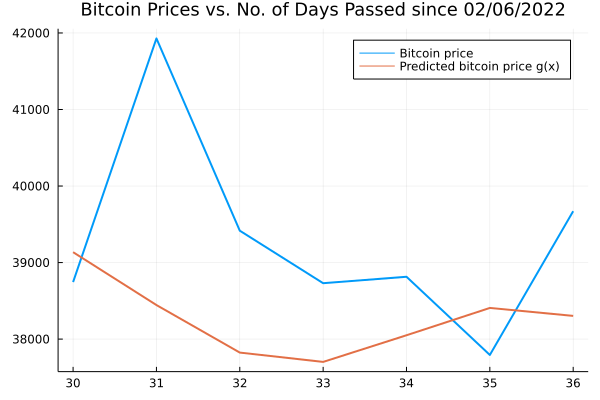

In [27]:
plot(A2[:,2], b2, title= "Bitcoin Prices vs. No. of Days Passed since 02/06/2022", titlefontsize=12, lw=2, legend= :topright, label="Bitcoin price")
plot!(A2[:,2],Predic, label="Predicted bitcoin price g(x)", lw=2)

The plot of our model for the initial dataset along with the seven days ahead (prediction):

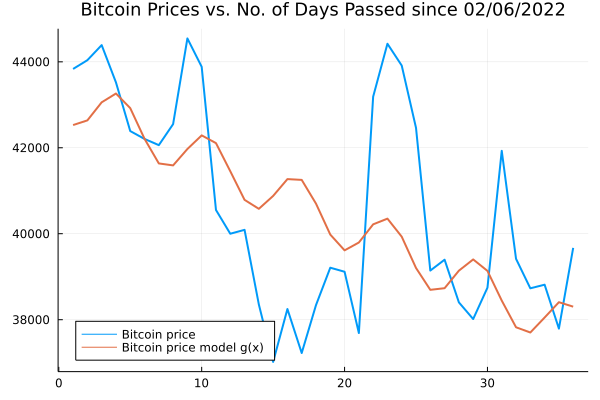

In [28]:
Af= [ATrig; A2]
bf= [b; b2]
yf=Af*xtrig


plot(Af[:,2], bf, title= "Bitcoin Prices vs. No. of Days Passed since 02/06/2022", titlefontsize=12, lw=2, legend= :bottomleft, label="Bitcoin price")
plot!(Af[:,2],yf, lw=2, label= "Bitcoin price model g(x)")


We can conclude that our model didn't encounter the problem of overfitting. In fact, the mean squared error of the prediction was less than the mean squared error of the model applied to the training set. We can also observe that the error of the bitcoin price model is relatively low. 

**3.** Use least squares to determine the relationship between the bitcoin price and prices of three comodities, namely, oil, silver and gold, during the last year.

First we read all commodities' and bitcoin's data of the year.

In [29]:
using CSV
using DataFrames

BitcoinYear = CSV.read("C:\\Users\\Ramos\\Documents\\Life\\University\\2022-1S\\Courses\\Aprendizaje de Máquina\\Tarea1\\Bityear.csv",DataFrame);
BitcoinYear.Price .= replace.(BitcoinYear.Price, "," => "");
BitcoinYear.BitcoinPrice = parse.(Float64, BitcoinYear.Price);
BitcoinYear=BitcoinYear[:,[1,8]]

GoldYear = CSV.read("C:\\Users\\Ramos\\Documents\\Life\\University\\2022-1S\\Courses\\Aprendizaje de Máquina\\Tarea1\\Goldyear.csv",DataFrame);
GoldYear.Price .= replace.(GoldYear.Price, "," => "");
GoldYear.GoldPrice = parse.(Float64, GoldYear.Price);
GoldYear=GoldYear[:,[1,8]]

OilYear = CSV.read("C:\\Users\\Ramos\\Documents\\Life\\University\\2022-1S\\Courses\\Aprendizaje de Máquina\\Tarea1\\Oilyear.csv",DataFrame);
OilYear.OilPrice=OilYear.Price
OilYear=OilYear[:,[1,8]]

SilverYear = CSV.read("C:\\Users\\Ramos\\Documents\\Life\\University\\2022-1S\\Courses\\Aprendizaje de Máquina\\Tarea1\\Silveryear.csv",DataFrame);
SilverYear.SilverPrice=SilverYear.Price
SilverYear=SilverYear[:,[1,8]]

ComPrice=innerjoin(SilverYear,GoldYear,on= :Date);
ComPrice=innerjoin(ComPrice,OilYear,on=:Date);
ComPrice=innerjoin(ComPrice,BitcoinYear,on=:Date);
ComPrice=ComPrice[reverse(Vector(1:263)),:];

Let $x,y,z$ be variables representing the prices of silver, gold, and oil respectively. We'll construct the following three models for the bitcoin price using least squares:

1. $f_1(x,y,z)=\alpha_1+\alpha_2x+\alpha_3y+\alpha_4z$
2. $f_2(x,y,z)=\beta_1+\beta_2x+\beta_3y+\beta_4z+\beta_5x^2+\beta_6y^2+\beta_7z^2$
3. $f_3(x,y,z)=\omega_1+\omega_2x+\omega_3y+\omega_4z+\omega_5x^2+\omega_6y^2+\omega_7z^2+\omega_8xy+\omega_9xz+\omega_{10}yz$

Where the $\alpha_i$'s, $\beta_i$'s and $\omega_i$'s are the parameters to be determined. 

Finally, to determine the relationship we'll choose the best model considering the squared error and the complexity of each one.

In [30]:
c=Array(ComPrice.BitcoinPrice);
x=ComPrice.SilverPrice;
y=ComPrice.GoldPrice;
z=ComPrice.OilPrice;
n= size(c,1);


A1=[ones(n,1) x y z];
A2=[ones(n,1) x y z x.^2 y.^2 z.^2];
A3=[ones(n,1) x y z x.^2 y.^2 z.^2 x.*y y.*z z.*x];

Now we calculate the solution that optimizes each model, and the mean squared error for each solution. 

In [31]:
s1=leastsq(A1,c);
s2=leastsq(A2,c);
s3=leastsq(A3,c);

e1=(1/n)*norm(s1[2]-c);
e2=1/n*norm(s2[2]-c);
e3=1/n*norm(s3[2]-c);

println("The least squares solutions for each model are, respectively:\n")

println(round.(s1[1],digits=3), ", with a mean least square error of ", round(e1,digits=3),".\n")
println(round.(s2[1],digits=3), ", with a mean least square error of ", round(e2,digits=3),".\n")
println(round.(s3[1],digits=3), ", with a mean least square error of ", round(e3,digits=3),".\n")

The least squares solutions for each model are, respectively:

[153640.454, -371.044, -54.441, 16.067], with a mean least square error of 522.269.

[-167752.74, 25987.363, -7.475, -1249.859, -541.507, -0.008, 6.891], with a mean least square error of 505.286.

[-310017.523, -2932.081, 609.52, -2639.528, -1586.519, -0.621, 2.511, 52.897, 3.972, -211.302], with a mean least square error of 494.716.



As can be observed, the error didn't improve by much adding the parameters of the $f_2$ and $f_3$ models, and because the first function is the simplest one in terms of complexity and the size of the solution's coeffitients as well, we'll choose the least squares solution of that function to be our model for the bitcoin price. 

Thus, we conclude that the relationship between the bitcoin price and the prices of the three comodities is given by the function 

$f_1(x,y,z)=153640.454_1+-371.044x+-54.441y+16.067z,$

where $x,y,z$ are the variables representing the prices of silver, gold, and oil respectively.

**4.** Solve the [point set registration problem](https://en.wikipedia.org/wiki/Point-set_registration). Hint (check: S. Umeyama, Least-Squares Estimation of Transformation Parameters Between Two Point Patterns, IEEE Trans. Pattern Anal. Mach. Intell., vol. 13, no. 4, 1991). Construct a GUI to test.

**${\large
Problem\hspace{2mm} formulation}$**

The point set registration problem formulation is the following:  given two point patterns $\left\{\boldsymbol{x}_{i}\right\}$ and $\left\{\boldsymbol{y}_{i}\right\}; i=1,2, \cdots, n$ in $m$-dimensional space, find a transformation $T$ to be applied to the point set $\left\{\boldsymbol{x}_{i}\right\}$ such that the mean squared error between $\{\boldsymbol{T}(\boldsymbol{x_i})\}$ and $\left\{\boldsymbol{y}_{i}\right\}$ is minimized.

In this case we'll consider the variation of the problem, where the $T$ is a similarity transformation. So we want to find the parameters ($R$ : rotation, $t$ : translation, and $c$ : scaling) such that the mean squared error $e^{2}(R, t, c)$ given by
$$
e^{2}(R, t, c)=\frac{1}{n} \sum_{i=1}^{n}\left\|\boldsymbol{y}_{i}-\left(c R \boldsymbol{x}_{i}+\boldsymbol{t}\right)\right\|^{2}
$$
is minimized.

**${\large
Theoretical\hspace{2mm}solution}$**






Define $\mu_x$, $\mu_y$, $\sigma_{x}$, $\sigma_{y}$ and $\Sigma_{x y}$ as

$$
\begin{aligned}
\boldsymbol{\mu}_{x} &=\frac{1}{n} \sum_{i=1}^{n} \boldsymbol{x}_{i}, \\
\boldsymbol{\mu}_{y} &=\frac{1}{n} \sum_{i=1}^{n} \boldsymbol{y}_{i}, \\
\sigma_{x}^{2} &=\frac{1}{n} \sum_{i=1}^{n}\left\|\boldsymbol{x}_{i}-\boldsymbol{\mu}_{x}\right\|^{2}, \\
\sigma_{y}^{2} &=\frac{1}{n} \sum_{i=1}^{n}\left\|\boldsymbol{y}_{i}-\boldsymbol{\mu}_{y}\right\|^{2}, \\
\Sigma_{x y} &=\frac{1}{n} \sum_{i=1}^{n}\left(\boldsymbol{y}_{i}-\boldsymbol{\mu}_{y}\right)\left(\boldsymbol{x}_{i}-\boldsymbol{\mu}_{x}\right)^{T},
\end{aligned}
$$

and let a singular value decomposition of $\Sigma_{x y}$ be $U D V^{T}(D=$ $\left.\operatorname{diag}\left(d_{i}\right), d_{1} \geq d_{2} \geq \cdots \geq d_{m} \geq 0\right)$, and

$$
S= \begin{cases}I & \text { if } \operatorname{det}\left(\Sigma_{x y}\right) \geq 0 \\ \operatorname{diag}(1,1, \cdots, 1,-1) & \text { if } \operatorname{det}\left(\Sigma_{x y}\right)<0\end{cases}
$$

**Considering the given reference**, we have that the minimum value $\varepsilon^{2}$ of the mean squared error
$e^{2}(R, t, c)$ of the point patterns with respect to parameters $R,t,c$ is given as
$$
\varepsilon^{2}=\sigma_{y}^{2}-\frac{\operatorname{tr}(D S)^{2}}{\sigma_{x}^{2}}.
$$

Moreover, when rank $\left(\Sigma_{x y}\right) \geq m-1$, the optimum transformation parameters are determined uniquely as follows:

$$
\begin{aligned}
R &=U S V^{T} \\
t &=\boldsymbol{\mu}_{y}-c R \boldsymbol{\mu}_{x} \\
c &=\frac{1}{\sigma_{x}^{2}} \operatorname{tr}(D S).
\end{aligned}
$$



**${\large
Code\hspace{2mm}for\hspace{2mm}solution\hspace{2mm}implementation}$**

To solve the previous formulated problem given the sets $\{x_i\}$ and $\{y_i\}$, we make a function that takes the point sets as arguments and calculates the optimum transformation parameters $R$, $c$ and $t$, assuming rank $\left(\Sigma_{x y}\right) \geq m-1$. In the case where the $x_i$ and $y_i$'s are 2-dimensional vectors (which will be the case of our example), this condition will easily be met since we'll only need $\Sigma_{x y}$ to be different from the zero matrix.

In [32]:
using Statistics

function variance(X)
    
    #=takes point set X, rep. by vector of equally-dimensioned vectors
    returns non-corrected variance of point set X =#   
    
    v=0
    for i in X
        v+= norm(i-mean(X))^2
    end
    return v/size(X,1)

end

function Covmatrix(X,Y)
    
    #=takes point sets X and Y, rep. by vectors of equally-dimensioned vectors
    returns non-corrected covariance matrix of point sets X and Y =#       
    
    siz = size(X[1],1)
    sigma = zeros(siz,siz)
    n = size(X,1)
    for i in 1:n
        sigma += (Y[i]-mean(Y))*transpose((X[i]-mean(X)))
    end
    return (1/n)*sigma
end;


function PSRPSolution(X,Y)
    
    #=takes X,Y vectors of vectors as values, 
    returns [c,R,t], where R,t,c are the optimum rotation, translation, and scaling parameters of the PSR Problem, respectively.
    =#
    
    siz = size(X[1],1);
    covmat = Covmatrix(X,Y);
    S = zeros(siz,siz)
    if det(covmat)>=0
        S = Matrix(I, siz, siz)
    else
        D = ones(siz)
        D[siz]=-1
        S = Diagonal(D)
    end
    svdmat = svd(covmat);
    R = svdmat.U*S*svdmat.Vt
    varx=variance(X)
    c = tr(Diagonal(svdmat.S)*S)/varx
    t = mean(Y)-(c*R*mean(X))   
    println(typeof(R))
    return [c,R,t]

end;

**${\large
Example\hspace{2mm}animation\hspace{2mm}}$**

We'll make an example of the problem's solution obtained using the previous function. In this case, we'll consider a point set $X=\{x_i\}$ which forms the shape of a heart, and a $Y=\{y_i\}$ point set which forms the shape of the same heart scaled, rotated and translated with scalar $c$, matrix $Rot$ and vector $t$ respectively, which will be defined as follows. 

Construction and scatter of point set $X$.

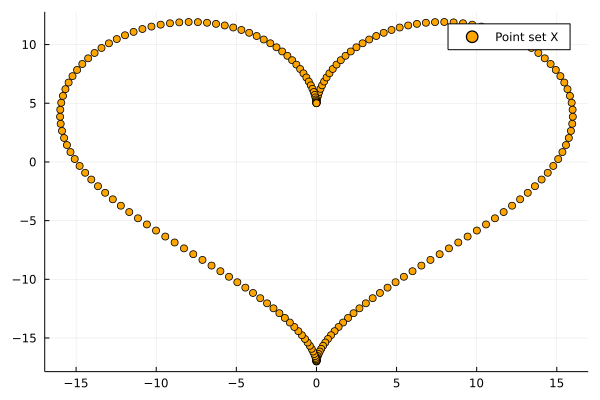

In [33]:
#X={x_i}_i construction

n=200;
the = range(0, 2π, length = n);
x1 = 16sin.(the).^3;
x2 = 13cos.(the) .- 5cos.(2the) .- 2cos.(3the) .- cos.(4the);

Xset= Array{Vector{Float64}}(undef,n);
for i in 1:n
    Xset[i]=[x1[i], x2[i]];
end;


Xset1=[Xset[i][1] for i in 1:n]
Xset2=[Xset[i][2] for i in 1:n]
scatter(Xset1, Xset2, label="Point set X", color="orange")

Construction and scatter of point set $Y$.

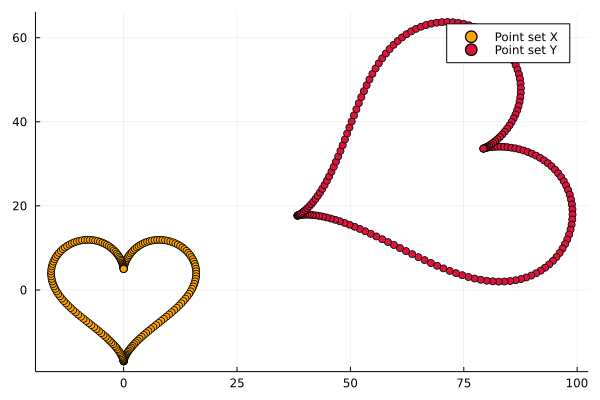

In [34]:
#Y={y_i}_i construction

Rotf(ang)=Array([cos(ang) -sin(ang); sin(ang) cos(ang)]);
t=[70,30];
c=2;

examplesetY(x)=c*Rotf(-1.2)*x+t;
Yset=map(examplesetY, Xset);

Yset1=[Yset[i][1] for i in 1:n]
Yset2=[Yset[i][2] for i in 1:n]
scatter!(Yset1, Yset2, label="Point set Y", color="crimson")

Now we implement the function that solves the PSR problem, and calculate the absolute error between the actual transformation parameters used for getting the point set $Y$, and the ones given by the PSRPSolution function.

In [35]:
#solving the PSR problem with the built code

Sol=PSRPSolution(Xset,Yset);

cerror=abs(c-Sol[1]);
Rerror=norm(Rotf(-1.2)-Sol[2])^2;
terror=norm(t-Sol[3])^2;

println("Absolute error of constant: ", round(cerror,digits= 4), "\n", "Absolute error of matrix: ", round(Rerror, digits= 4), "\n", "Absolut error of vector: ", round(terror, digits= 4))


Matrix{Float64}
Absolute error of constant: 0.0
Absolute error of matrix: 0.0
Absolut error of vector: 0.0


We observe that the function calculated all the similarity transformation parameters perfectly. Now we can make an animation with the $X$ and $Y$ point sets, and the solution transformation being applied to the point set $X$.

┌ Info: Saved animation to 
│   fn = C:\Users\Ramos\Downloads\tmp.gif
└ @ Plots C:\Users\Ramos\.julia\packages\Plots\8K4be\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Ramos\\Downloads\\tmp.gif")
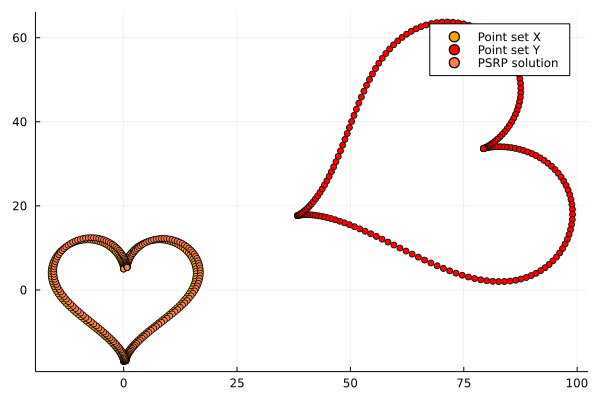

In [36]:
ng=100

function Soltrans(i)
    st=(1+(Sol[1]-1)/ng*i)*Rotf(-1.2/ng*i)
    return st
end; 


@gif for i in 1:ng
     f(x)=Soltrans(i)*x+Sol[3]/ng*i    
     Z=map(f,Xset)
     Z1=[Z[i][1] for i in 1:n]
     Z2=[Z[i][2] for i in 1:n]
     scatter(Xset1, Xset2, label="Point set X", color="orange")
     scatter!(Yset1, Yset2, label="Point set Y", color="red")
     scatter!(Z1,Z2,color="coral", label="PSRP solution")
     end

